In [1]:
import os,sys
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
from plotnine import *
from functools import reduce
from pathlib import Path
import re
import glob

In [46]:
qc_path = '/Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/qc_stats'
df1 = pd.read_csv(os.path.join(qc_path, 'metadata_all_lane_qc.csv'))
df1.set_index('Unnamed: 0', inplace= True)

In [40]:
df_plot = (
    df1
    .groupby(['experiment', 'sgRNA_type'], as_index=False)
    .agg(mean_total_counts=('total_counts', 'mean'),
        mean_genes_per_cell = ('n_genes_by_counts', 'mean'),
        mean_guide_umi_counts = ('UMI_counts', 'mean'))
)
df_plot['mean_guide_umi_counts'] = df_plot['mean_guide_umi_counts'].fillna(0)
df_plot

,experiment,sgRNA_type,mean_total_counts,mean_genes_per_cell,mean_guide_umi_counts
0,Mac_L01_Mac_Ctrl,multi sgRNA,11412.186465,3850.395627,114.190031
1,Mac_L01_Mac_Ctrl,single NTC sgRNA,10736.917282,3739.196434,73.995342
2,Mac_L01_Mac_Ctrl,single sgRNA,10597.148930,3712.606773,95.423852
3,Mac_L01_Mac_LPS,multi sgRNA,12798.400975,3845.091331,145.142958
4,Mac_L01_Mac_LPS,single NTC sgRNA,11868.429699,3687.559130,97.197647
5,Mac_L01_Mac_LPS,single sgRNA,11792.904597,3673.355466,125.709992
6,Mac_L02_Mac_Ctrl,multi sgRNA,14366.373070,4323.923335,127.910581
7,Mac_L02_Mac_Ctrl,single NTC sgRNA,13472.308986,4209.335989,82.388963
8,Mac_L02_Mac_Ctrl,single sgRNA,13325.819715,4182.821756,109.052676
9,Mac_L02_Mac_LPS,multi sgRNA,16139.258201,4294.920830,161.864667


In [41]:
df1_long = df1.melt(
    id_vars=['experiment', 'sgRNA_type'],
    value_vars=['total_counts', 'n_genes_by_counts', 'UMI_counts'],
    var_name='metric',
    value_name='value'
)

# optional: nicer facet names
df1_long['metric'] = df1_long['metric'].map({
    'total_counts': 'Mean mRNA UMIs per cell',
    'n_genes_by_counts': 'Mean genes per cell',
    'UMI_counts': 'Mean guide UMI counts'
})

# ensure numeric + drop missing
df1_long['value'] = pd.to_numeric(df1_long['value'], errors='coerce')
df1_long = df1_long.dropna(subset=['value'])
parts = df1_long['experiment'].str.split('_', expand=True)
df1_long['experiment'] = parts[0] + ' ' + parts[1] + ' ' + parts.iloc[:, -1]

In [43]:
# # Order the rows
type_order = ['single sgRNA','single NTC sgRNA','multi sgRNA']
df1_long['sgRNA_type'] = pd.Categorical(df1_long['sgRNA_type'],categories=type_order,ordered=True)

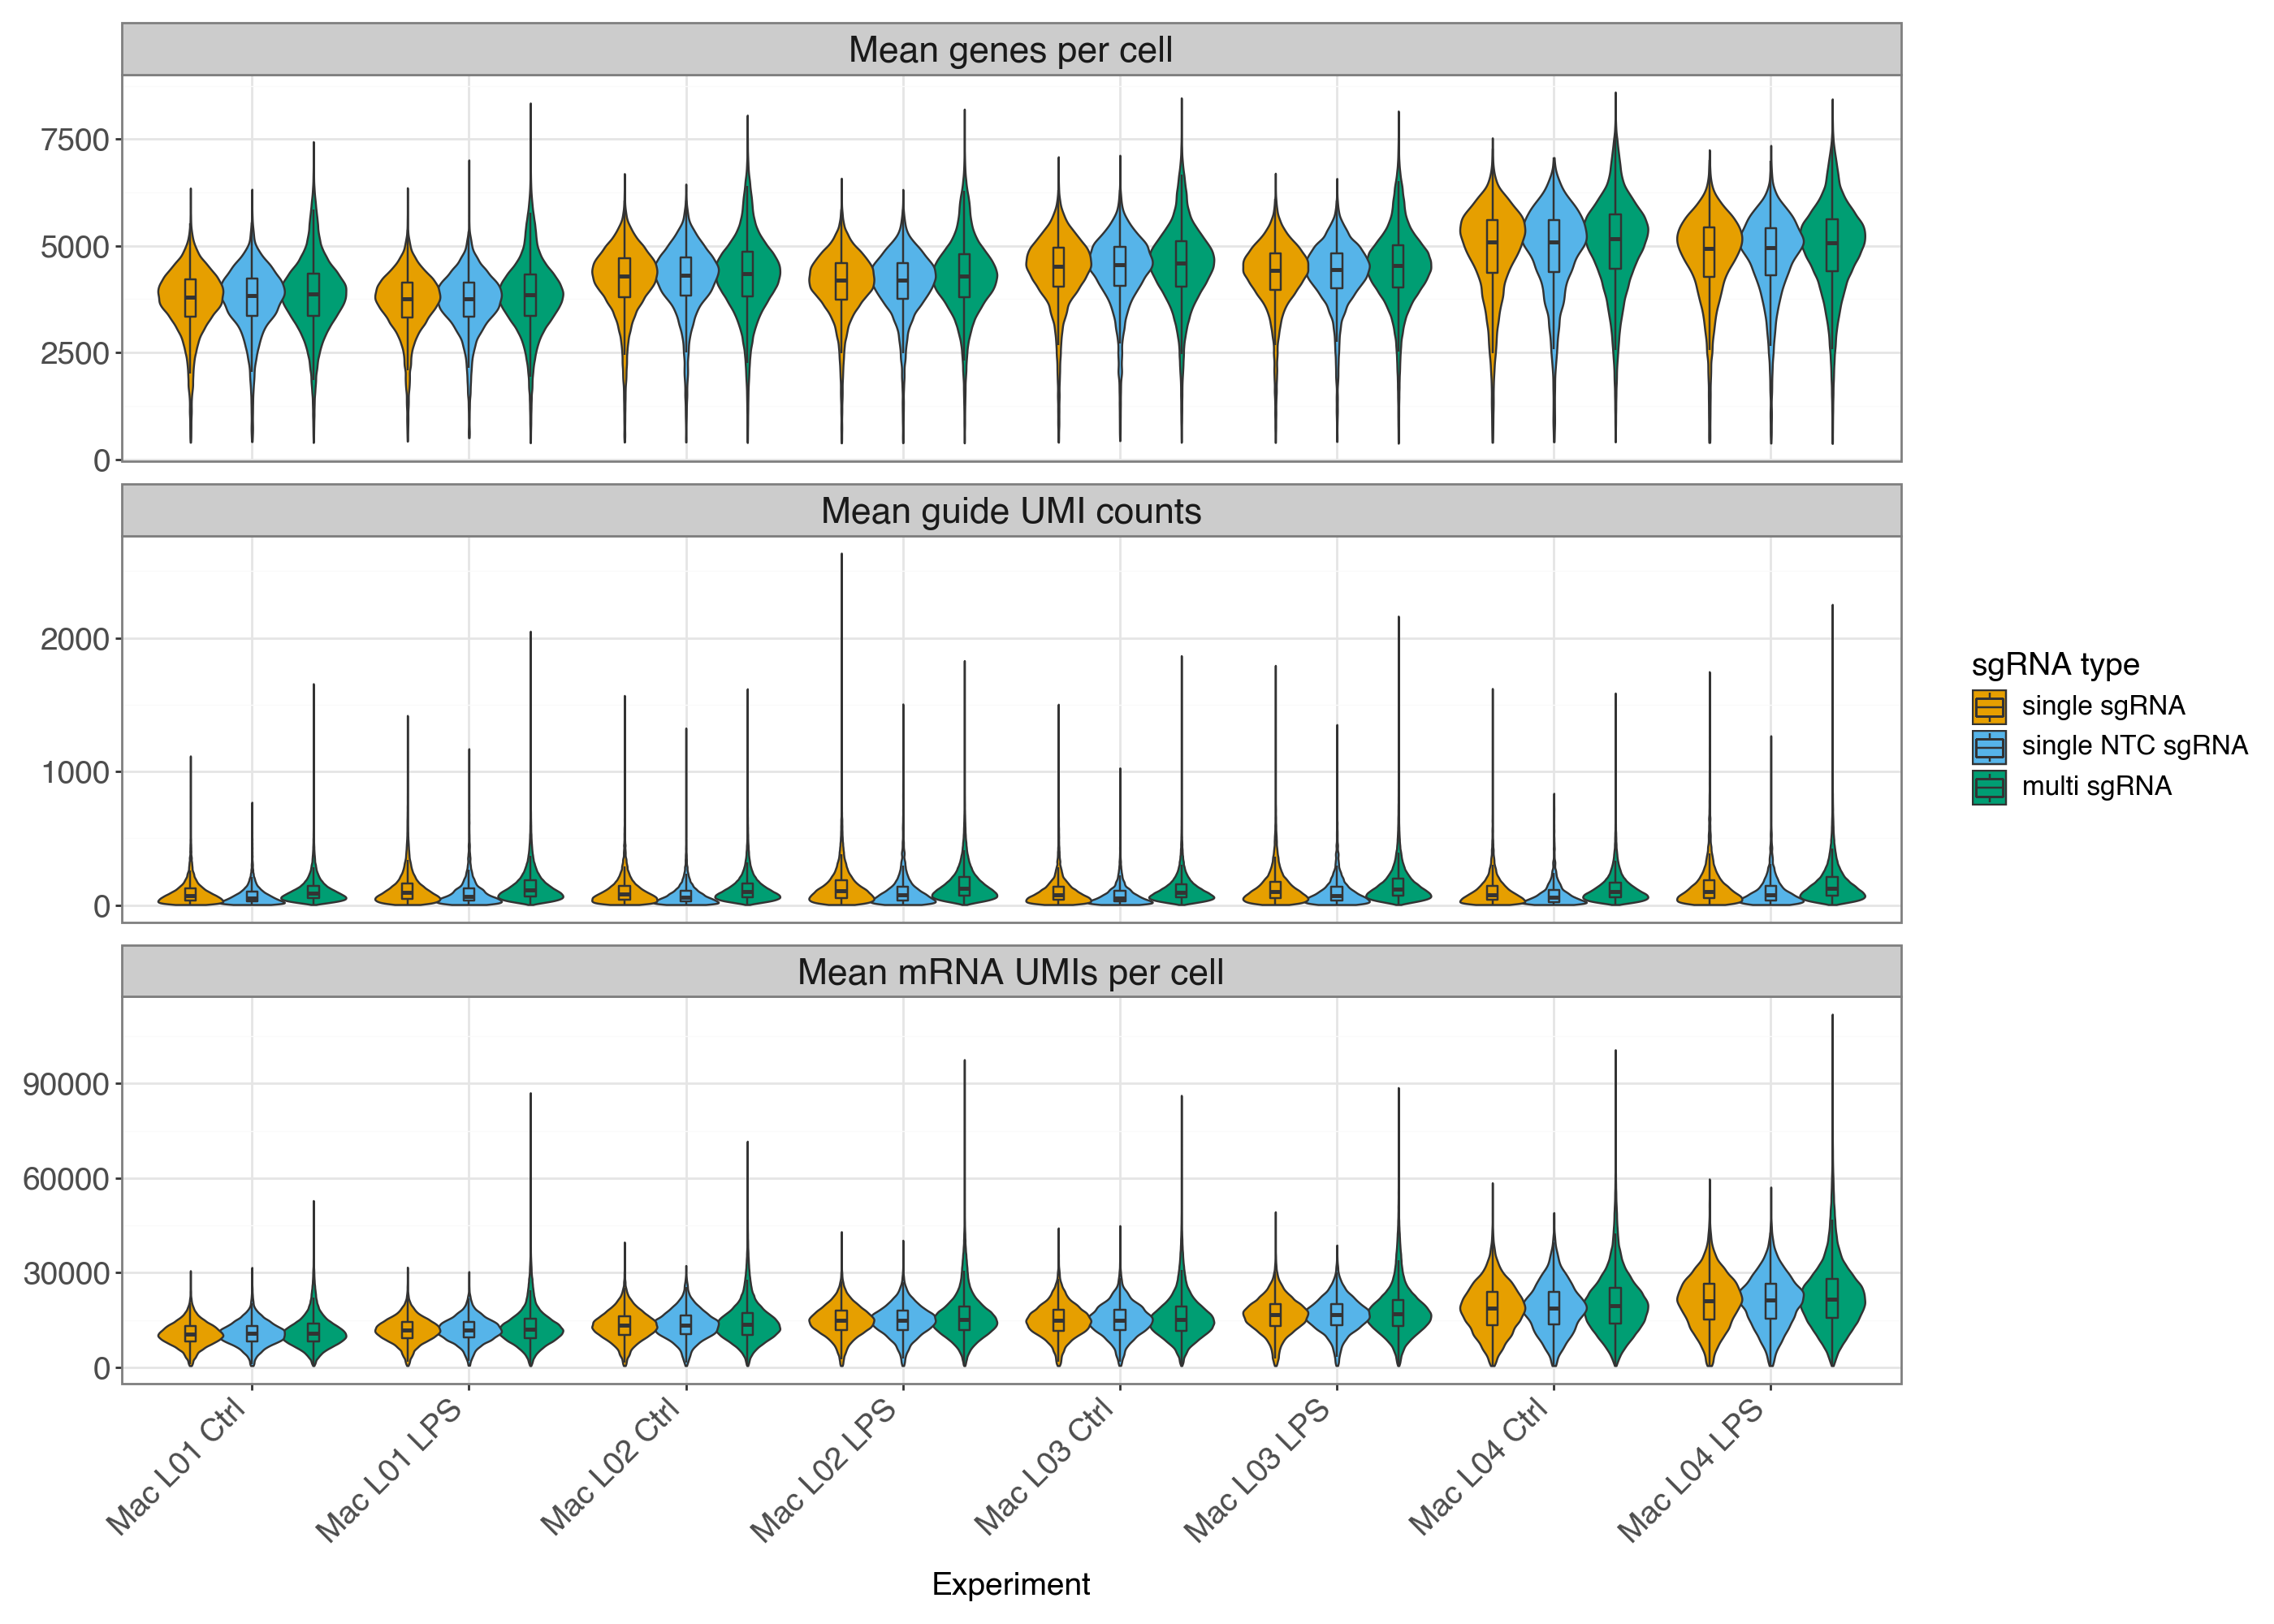

In [45]:
dodge = position_dodge(width=0.85)

p = (
    ggplot(df1_long, aes(x='experiment', y='value', fill='sgRNA_type'))
    + geom_violin(position=dodge, trim=True, scale='width')
    + geom_boxplot(position=dodge, width=0.15, outlier_alpha=0)
    + facet_wrap('~metric', scales='free_y', nrow=3)
    + scale_fill_manual(values=['#E69F00', '#56B4E9', '#009E73']) 
    + labs(x='Experiment', y='', fill='sgRNA type')
    + theme_bw()
    + theme(
        axis_text_x = element_text(rotation=45, ha='right', size=14),  # x ticks
        axis_text_y = element_text(size=14),                          # y ticks
        axis_title_x = element_text(size=14),                         # axis title
        axis_title_y = element_text(size=14),

        legend_text = element_text(size=12),                          # legend labels
        legend_title = element_text(size=14),                         # legend title

        strip_text = element_text(size=16),                           # facet titles
        figure_size = (14, 10)
    )
)

p

In [ ]:
plt_path = '/Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/plots'
p.save(os.path.join(plt_path, 'mRNA_UMI_counts_by_guide_type_violin.png'), dpi= 300)

/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 14 x 10 in image.
/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/plots/mRNA_UMI_counts_by_guide_type_violin.png
